# Item-based Filtering Enhanced by SVD - Spring 2024 Term Project


#### Kaan Yücel - 150210318

In [6]:
import time
import numpy as np
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

### SVD implementation

In order to use singular value decomposition,we need to find eigenvalue and eigenvectors.QR decomposition is one of the ways to find the eigenvalues.
Implementation of QR decomposition:

In [7]:
def qr_decompositions(A): # A: matrix 
    n = len(A)
    Q_matrix = np.zeros((n, n))
    R_matrix = np.zeros((n, n))
    # assign first element of Q and R
    Q_matrix[:, 0] = A[:, 0] / np.linalg.norm(A[:, 0])  
    R_matrix[0, 0] = np.linalg.norm(A[:, 0])  
    for i in range(1, n):
        column = A[:, i]
        for k in range(i):
            q = Q_matrix[:, k]
            # substracting the projections
            column = column - (column.T @ q) * q
        # new column of Q: v
        v = column / np.linalg.norm(column)
        Q_matrix[:, i] = v
        # filling the R matrix
        R_matrix[i, i] = np.linalg.norm(column)
        for j in range(i, n):
            R_matrix[i - 1, j] = A[:, j].T @ Q_matrix[:, i - 1]
    return Q_matrix, R_matrix

I iterated the qr compositions and result is becoming a upper triangular matrix which its eigenvalues on the diagonal but first i
transformed the matrix to hessenberg form to ease the computations

In [8]:
def transform_hessenberg(A): # A: matrix
    n = len(A)
    H = A
    for i in range(n - 2):
        for j in range(i + 2, n):
            G = np.eye(n)
            a = (H[i + 1, i] ** 2 + H[j, i] ** 2) ** (1 / 2)
            c = H[i + 1, i] / a
            s = H[j, i] / a
            G[i + 1, i + 1] = c
            G[j, j] = c
            G[i + 1, j] = s
            G[j, i + 1] = -s 
            H = G @ H @ G.T
    return H

In [9]:
def eigenvalue_vectors(A,k): #A: matrix, k:iteration parameter
    # transforming matrix to hessenberg form to ease the computations
    H = transform_hessenberg(A) 
    n = len(A)
    I = np.eye(n)
    # iteration of qr decompositions
    for i in range(k*n): 
        Q, R = qr_decompositions(H)
        H = R @ Q

    # H is upper triangular
    eigenvalues = np.diag(H)
    # Sorting the eigenvalues and find the corresponding eigenvectors with nullspace
    eigenvalues = np.sort(eigenvalues)[::-1]
    print(eigenvalues)
    eigenvectors = []
    for eigval in eigenvalues:
        x = linalg.null_space(A - eigval * I)
        eigenvectors.append(x)
    return eigenvalues, eigenvectors

Now that we have eigenvalues and eigenvectors,we can form svd

In [10]:
def svd(A,k,c): # A: matrix,k: rank,c: iteration parameter
    
    m, n = A.shape
    U = np.zeros((m, k))
    VT = np.zeros((k, n))
    E = np.zeros((k, k))
    #  find the eigenvalues and vectors of A@A.T to form the U matrix because it is easier to compute assuming n >> m
    eigvalues, eigvectors = eigenvalue_vectors(A@A.T,c)
    #  forming the U, E, V.T matrices
    for i in range(k):
        E[i, i] = eigvalues[i] ** (1 / 2)
        U[:, i] = eigvectors[i].reshape(-1)
        VT[i, :] = (1 / E[i, i]) * A.T @ U[:, i]
    return U, E, VT

### Data Preprocessing

In [11]:
df = pd.read_json("dataset/sample.json")  # Reading the data
df = df[["reviewer", "movie", "rating"]]
df

,reviewer,movie,rating
0,OriginalMovieBuff21,Kill Bill: Vol. 2 (2004),8.0
1,sentra14,Journey to the Unknown (1968– ),NaN
2,GreenwheelFan2002,The Island (2005),9.0
3,itsascreambaby,Win a Date with Tad Hamilton! (2004),3.0
4,OriginalMovieBuff21,Saturday Night Live: The Best of Chris Farley ...,10.0
...,...,...,...
99995,shaleina03,Brokeback Mountain (2005),10.0
99996,DanB-4,Eternal Sunshine of the Spotless Mind (2004),9.0
99997,marilutravis,Summer's Lease (1989– ),10.0
99998,NYCDude,Loggerheads (2005),10.0


In [12]:
# Group by reviewer and count the number of movies reviewed
reviewer_counts = df.groupby(by="reviewer").count()["movie"]
# Filter to only include reviewers with more than 20 counts
df_20 = reviewer_counts[reviewer_counts >= 20]
# Filter the original DataFrame based on the reviewers with more than 20 counts
filtered_df = df[df["reviewer"].isin(df_20.index)]
filtered_df = filtered_df.sort_values(by="reviewer").reset_index(drop=True)
filtered_df

,reviewer,movie,rating
0,AZINDN,Passionada (2002),8.0
1,AZINDN,The Phantom of the Opera (2004),10.0
2,AZINDN,Velvet Goldmine (1998),9.0
3,AZINDN,A Life Less Ordinary (1997),4.0
4,AZINDN,Angels in America (2003),2.0
...,...,...,...
24888,zetes,The 40-Year-Old Virgin (2005),7.0
24889,zetes,The Sword of Doom (1966),10.0
24890,zetes,Breakin' (1984),8.0
24891,zetes,North Country (2005),6.0


In [13]:
# creating the reviewer-movie matrix
R = filtered_df.pivot_table(index="reviewer", columns="movie", values="rating") 
column_averages = R.mean()
for column in R.columns:
    R.fillna({column: column_averages[column]}, inplace=True)
R_filledin = R
row_averages = R_filledin.mean(axis=1)

# Subtract row averages from each row in the matrix
R_norm = R_filledin.copy()  # Make a copy of the filled-in matrix
for index, row_average in row_averages.items():
    R_norm.loc[index] = R_filledin.loc[index] - row_average
# Now lets find the Singular Value Decomposition
R_norm=R_norm/2
R_norm

movie,$ (1971),'G' Men (1935),'Halloween' Unmasked 2000 (1999 Video),'Hellboy': The Seeds of Creation (2004),'It's Alive!' (1969 TV Movie),'R Xmas (2001),'Round Midnight (1986),"'Sheba, Baby' (1975)",'Weird Al' Yankovic: The Ultimate Video Collection (2003 Video),(T)Raumschiff Surprise - Periode 1 (2004),...,"¡Ay, Carmela! (1990)",¿Dónde estás amor de mi vida que no te puedo encontrar? (1992),À Nos Amours (1983),À la folie... pas du tout (2002),À mort l'arbitre! (1984),Æon Flux (2005),Ça commence aujourd'hui (1999),Çilgin kiz ve üç süper adam (1973),Échec au porteur (1958),Élise ou la vraie vie (1970)
reviewer,,,,,,,,,,,,,,,,,,,,,
AZINDN,0.145839,0.645839,1.645839,0.145839,-0.354161,0.645839,0.645839,-1.354161,1.145839,0.145839,...,-0.354161,0.645839,-0.854161,0.895839,0.145839,-0.354161,1.145839,0.145839,0.145839,0.645839
Aaron1375,0.145346,0.645346,1.645346,0.145346,-0.354654,0.645346,0.645346,-1.354654,1.145346,0.145346,...,-0.354654,0.645346,-0.854654,0.895346,0.145346,-0.354654,1.145346,0.145346,0.145346,0.645346
Andreas_N,0.144973,0.644973,1.644973,0.144973,-0.355027,0.644973,0.644973,-1.355027,1.144973,0.144973,...,-0.355027,0.644973,-0.855027,0.894973,0.144973,-0.355027,1.144973,0.144973,0.144973,0.644973
Antagonisten,0.147467,0.647467,1.647467,0.147467,-0.352533,0.647467,0.647467,-1.352533,1.147467,0.147467,...,-0.352533,0.647467,-0.852533,0.897467,0.147467,-0.352533,1.147467,0.147467,0.147467,0.647467
Atavisten,0.146263,0.646263,1.646263,0.146263,-0.353737,0.646263,0.646263,-1.353737,1.146263,0.146263,...,-0.353737,0.646263,-0.853737,0.896263,0.146263,-0.353737,1.146263,0.146263,0.146263,0.646263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wmorrow59,0.145752,0.645752,1.645752,0.145752,-0.354248,0.645752,0.645752,-1.354248,1.145752,0.145752,...,-0.354248,0.645752,-0.854248,0.895752,0.145752,-0.354248,1.145752,0.145752,0.145752,0.645752
world_of_weird,0.146431,0.646431,1.646431,0.146431,-0.353569,0.646431,0.646431,-1.353569,1.146431,0.146431,...,-0.353569,0.646431,-0.853569,0.896431,0.146431,-0.353569,1.146431,0.146431,0.146431,0.646431
wrestlingsitewebmaster,0.145401,0.645401,1.645401,0.145401,-0.354599,0.645401,0.645401,-1.354599,1.145401,0.145401,...,-0.354599,0.645401,-0.854599,0.895401,0.145401,-0.354599,1.145401,0.145401,0.145401,0.645401


In [14]:
# converting matrix to numpy array
A=R_norm.to_numpy()
R_filledin

movie,$ (1971),'G' Men (1935),'Halloween' Unmasked 2000 (1999 Video),'Hellboy': The Seeds of Creation (2004),'It's Alive!' (1969 TV Movie),'R Xmas (2001),'Round Midnight (1986),"'Sheba, Baby' (1975)",'Weird Al' Yankovic: The Ultimate Video Collection (2003 Video),(T)Raumschiff Surprise - Periode 1 (2004),...,"¡Ay, Carmela! (1990)",¿Dónde estás amor de mi vida que no te puedo encontrar? (1992),À Nos Amours (1983),À la folie... pas du tout (2002),À mort l'arbitre! (1984),Æon Flux (2005),Ça commence aujourd'hui (1999),Çilgin kiz ve üç süper adam (1973),Échec au porteur (1958),Élise ou la vraie vie (1970)
reviewer,,,,,,,,,,,,,,,,,,,,,
AZINDN,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0
Aaron1375,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0
Andreas_N,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0
Antagonisten,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0
Atavisten,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wmorrow59,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0
world_of_weird,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0
wrestlingsitewebmaster,7.0,8.0,10.0,7.0,6.0,8.0,8.0,4.0,9.0,7.0,...,6.0,8.0,5.0,8.5,7.0,6.0,9.0,7.0,7.0,8.0


### SVD and Prediction

In [15]:
n_iter = 10  # qr computation factor to find eigenvalues(number of iterations=matrix length * n_iter)
max_k = 20  # max rank number to approximate matrix with svd
m,n=A.shape

In [16]:
# calculating svd with max k value
u,e,vt=svd(A,max_k,n_iter)
# eigenvalues printed below

[4683891.93490938     324.2341682      251.69192363     235.8710284
     185.7535933      181.22869059     142.14506306     139.86817557
     128.11377209     124.72576346     120.38377923     117.3395395
     111.78194362     106.01757763     104.04995152      98.01618794
      95.94719388      93.50461482      92.75375543      90.52442516
      88.91375817      87.43852752      85.64552687      83.15324729
      80.54649269      79.34236915      76.66104748      75.51748121
      74.49195378      73.59823006      72.13975629      71.18748464
      69.93968591      67.16881215      66.72890218      66.07439658
      64.11707067      62.87774446      61.35389902      60.19841837
      59.30965685      58.95290934      58.0423057       56.82936472
      54.71304588      53.48565306      52.79335854      52.30860805
      51.0206897       50.60431998      49.30829437      48.55565883
      48.17425724      46.91039811      46.3782155       45.8581403
      44.99994639      44.01121928   

In [17]:
def cosine_sim(svt):
    adjcorr = np.zeros((n, n)) # Adjusted Cosine Similarity
    # Calculate the similarity between items item_j and item_f.Values are between -1 and 1
    for j in range(n):
        for f in range(j,n):
            adjcorr[j,f]=(svt[:,j]@svt[:,f])/((np.linalg.norm(svt[:,j])**2 * np.linalg.norm(svt[:,f])**2)**(1/2))
            adjcorr[f,j]=adjcorr[j,f]
    return adjcorr

Prediction function which calculates the prediction for user_a on item_j.

In [18]:
def pred(a,j,l,adjcorr): # a: user_a, j: item_j, l: neighbourhood
    R_test=R_filledin/2
    
    # making it dictionary to keep track of the column index
    neighbourhood_dict={i:value for i,value in enumerate(adjcorr[a])}
    
    # sorting the neighbourhood and get the first 'l' elements
    sorted_neighbourhood = dict(sorted(neighbourhood_dict.items(), key=lambda item: item[1],reverse=True))
    neighbourhood = {k: sorted_neighbourhood[k] for k in list(sorted_neighbourhood.keys())[:l]}
    neighbourhood_values=np.array(list(neighbourhood.values()))
    
    # row average
    row_average = R_test.mean(axis=1).iloc[a] # 8.16 change
    rr=R_norm.iloc[a,list(neighbourhood.keys())].to_numpy()
    rr_plus_average=rr+row_average
    
    numerator=neighbourhood_values @ rr_plus_average
    denominator=np.linalg.norm(neighbourhood_values, ord=1)
    
    return numerator/denominator,R_test.iloc[a,j]


In [19]:
def experiment(u,e,vt,k,l,row,column):
    # u: U matrix
    # e: Sigma matrix
    # vt :V.T matrix
    # k: rank
    # l: neighbourhood size
    # row,column: to determine how many predictions to make
    u_k=u[:,:k]
    vt_k=vt[:k,:]
    e_k=e[:k,:k]
    
    s_k=np.sqrt(e_k)
    us=u_k@s_k
    svt=s_k@vt_k # ---> meta ratings matrix whose entries represent the ”meta” ratings provided by the k pseudo-users on the n items. 

    cos_sim=cosine_sim(svt)

    mean_abs_error=0
    for a in range(row):
        for j in range(column):
            prediction,real=pred(a,j,l,cos_sim)
            mean_abs_error+=abs(prediction-real)
    return mean_abs_error/(row*column)

### Experiments

Testing k values

In [20]:
experiment_list_k=[]

In [21]:
# Parameters
k=2 # rank
l=20 # neighbourhood size
row=50
column=500
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_k.append(mae)
mae

1.111209717846918

In [22]:
# Parameters
k=4 # rank
l=20 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_k.append(mae)
mae

1.0676608712496525

In [23]:
# Parameters
k=6 # rank
l=20 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_k.append(mae)
mae

1.07586218735927

In [24]:
# Parameters
k=8 # rank
l=20 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_k.append(mae)
mae

1.0686354631811272

In [25]:
# Parameters
k=10 # rank
l=20 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_k.append(mae)
mae

1.0716766143123997

In [26]:
# Parameters
k=20 # rank
l=20 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_k.append(mae)
mae

1.0719891299874649

Testing neighbourhood values

In [27]:
experiment_list_l=[]

In [28]:
# Parameters
k=6 # rank
l=20 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_l.append(mae)
mae

1.07586218735927

In [29]:
# Parameters
k=6 # rank
l=40 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_l.append(mae)
mae

1.0720182154159827

In [30]:
# Parameters
k=6 # rank
l=60 # neighbourhood size
row=50
column=200
mae=experiment(u,e,vt,k,l,row,column)
exp1=[k,l,mae]
experiment_list_l.append(mae)
mae

1.0702381527851996

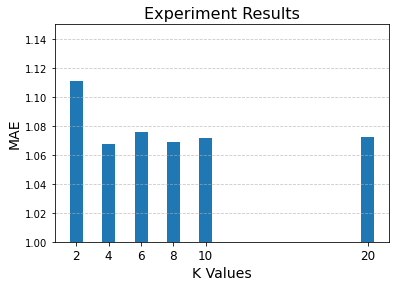

In [39]:
k_values=[2,4,6,8,10,20]
plt.bar(k_values,experiment_list_k)
plt.title('Experiment Results', fontsize=16)
plt.xlabel('K Values', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.ylim(1, 1.15)
plt.xticks(k_values, fontsize=12)  # Set custom ticks and their labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

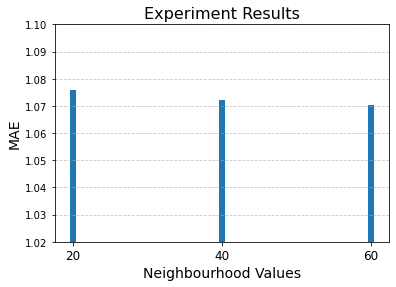

In [42]:
l_values=[20,40,60]
plt.bar(l_values,experiment_list_l)
plt.title('Experiment Results', fontsize=16)
plt.xlabel('Neighbourhood Values', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.ylim(1.02, 1.1)
plt.xticks(l_values, fontsize=12)  # Set custom ticks and their labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()